## 关键要点

清洗这个项目的数据时要牢记几个要点：  
- 我们只需要含有图片的原始评级 (不包括转发)。尽管数据集中有 5000 多条数据，但是并不是所有都是狗狗评分，并且其中有一些是转发。（含图片、是狗狗评分、原始评级（不要转发的））
- 本项目的要求只是评估和清理此数据集中的至少 8 个质量问题和至少 2 个整洁度问题。
- 合并三个数据片段


## 完善twitter档案
WeRateDogs 的推特档案包括 5000 多条推特的基本信息。  
档案中有一列包含每个推特的文本，我用这一列数据提取了评分、狗的名字和“地位”（即 doggo、floofer、pupper 和 puppo）——这使数据得以“完善”。在这 5000 多条中，我只筛选出了 2356 条包含评分的推特数据。

注意其中的评分、狗的名字和地位都有不正确的，如果想用它们进行分析和可视化，你需要评估和清洗这些列。

twitter-archive-enhanced.csv

## 通过推特 API 获取附加数据

**转发数（retweet count）**和**喜爱数（favorite count）**
需要从推特ID中获取 tweet_json.txt

## 图像预测文件

获取的结果：一份图像预测结果表格，其中包含了预测结果的前三名，推特 ID，图像 url 以及最可信的预测结果对应的图像编号（由于推特最多包含 4 个图片，所以编号为 1 到 4）。

以该表格中的最后一行数据来理解各列数据：

   tweet_id 是推特链接的最后一部分，位于 "status/" 后面 → https://twitter.com/dog_rates/status/889531135344209921
    jpg_url 是预测的图像资源链接
    img_num 最可信的预测结果对应的图像编号 → 1 推特中的第一张图片
    p1 是算法对推特中图片的一号预测 → 金毛犬
    p1_conf 是算法的一号预测的可信度 → 95%
    p1_dog 是一号预测该图片是否属于“狗”（有可能是其他物种，比如熊、马等） → True 真
    p2 是算法对推特中图片预测的第二种可能性 → 拉布拉多犬
    p2_conf 是算法的二号预测的可信度 → 1%
    p2_dog 是二号预测该图片是否属于“狗” → True 真
    以此类推...

这个文件你需要使用 Python 的 Requests 库和以下提供的 URL 来进行编程下载。下载用的 URL：https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv 。

## 步骤

### 0. 收集并合并数据集
Jupyter Notebook 中记录评估过程和结果，最终列出至少 8 个质量问题 和 2 个清洁度问题。

In [1]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import csv
import re
import json
from pprint import pprint
import random
import functools

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


In [2]:
# twitter-archive-enhanced.csv -> df_tae
df_tae = pd.read_csv("twitter-archive-enhanced.csv")
df_tae_copy = df_tae.copy()
display.display(df_tae_copy)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,nan,nan,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,nan,nan,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,nan,nan,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,nan,nan,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,nan,nan,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,nan,nan,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,nan,nan,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,nan,nan,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [6]:
# tweet_json.txt -> df_twt_json
df_twt_json = pd.DataFrame(columns=['tweet_id', 'jpg_url', 'img_num', 
#                                     'text', 
                                    'retweet_count', 'favorite_count'])
except_list = []
with open("tweet_json.txt") as f:

    for index, line in enumerate(f.readlines()):
        try:
            dct = json.loads(line)
            tweet_id = dct["entities"]["media"][0]['expanded_url'].split(sep='/')[-3]
            retweet_count = dct["retweet_count"]
            favorite_count = dct["favorite_count"]
            text = dct["full_text"]
            for i, d in enumerate(dct["extended_entities"]["media"],start=1):
                jpg_url = d["media_url_https"]
                img_num = i
                df_twt_json.loc[df_twt_json.shape[0]] = \
                    {'tweet_id':tweet_id, 
                     'jpg_url':jpg_url, 
                     'img_num':img_num, 
#                      'text':text, 
                     'retweet_count':retweet_count, 
                     'favorite_count':favorite_count}
        except KeyError as e:
#             print('except:', index,":\t",e)
            except_list.append(index)
df_twt_json = df_twt_json.astype({'tweet_id':np.int64,
                   'img_num':np.int64,
                   'retweet_count': np.int64,
                   'favorite_count': np.int64}, copy=False)
df_twt_json.dtypes
display.display(df_twt_json)

,tweet_id,jpg_url,img_num,retweet_count,favorite_count
0,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,8842,39492
1,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,6480,33786
2,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,4301,25445
3,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,8925,42863
4,891327558926688256,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,1,9721,41016
...,...,...,...,...,...
2939,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,41,111
2940,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,147,309
2941,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,47,128
2942,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,48,132


In [7]:
# image_predictions.tsv -> df_img_pre
import csv
import requests
url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'
with requests.Session() as s:
    s.post(url)
    download = s.get('https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv')

with open('image_predictions_tmp.tsv', 'w') as f:
    f.write(download.content.decode('ascii'))

df_img_pre = pd.read_csv('image_predictions_tmp.tsv', sep='\t')
df_img_pre

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.5,True,collie,0.2,True,Shetland_sheepdog,0.1,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.5,True,miniature_pinscher,0.1,True,Rhodesian_ridgeback,0.1,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.6,True,malinois,0.1,True,bloodhound,0.1,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.4,True,redbone,0.4,True,miniature_pinscher,0.2,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.6,True,Rottweiler,0.2,True,Doberman,0.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.6,True,English_springer,0.2,True,German_short-haired_pointer,0.2,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.2,False,Labrador_retriever,0.2,True,spatula,0.0,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.7,True,malamute,0.1,True,kelpie,0.0,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.3,True,Pekinese,0.1,True,papillon,0.1,True


In [8]:
# merge above 3 dataframes: 
# - df_tae_copy
# - df_twt_json
# - df_img_pre
df_tae_complete = df_tae_copy.merge(df_twt_json, how='inner', on='tweet_id').merge(df_img_pre, how='inner', on='tweet_id')
display.display(df_tae_complete)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num_y,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,nan,nan,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,...,1,orange,0.1,False,bagel,0.1,False,banana,0.1,False
1,892177421306343426,nan,nan,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,...,1,Chihuahua,0.3,True,Pekinese,0.1,True,papillon,0.1,True
2,891815181378084864,nan,nan,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,...,1,Chihuahua,0.7,True,malamute,0.1,True,kelpie,0.0,True
3,891689557279858688,nan,nan,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,...,1,paper_towel,0.2,False,Labrador_retriever,0.2,True,spatula,0.0,False
4,891327558926688256,nan,nan,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,...,2,basset,0.6,True,English_springer,0.2,True,German_short-haired_pointer,0.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,666049248165822465,nan,nan,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,nan,nan,NaN,https://twitter.com/dog_rates/status/666049248...,...,1,miniature_pinscher,0.6,True,Rottweiler,0.2,True,Doberman,0.2,True
2919,666044226329800704,nan,nan,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,nan,nan,NaN,https://twitter.com/dog_rates/status/666044226...,...,1,Rhodesian_ridgeback,0.4,True,redbone,0.4,True,miniature_pinscher,0.2,True
2920,666033412701032449,nan,nan,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,nan,nan,NaN,https://twitter.com/dog_rates/status/666033412...,...,1,German_shepherd,0.6,True,malinois,0.1,True,bloodhound,0.1,True
2921,666029285002620928,nan,nan,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,nan,nan,NaN,https://twitter.com/dog_rates/status/666029285...,...,1,redbone,0.5,True,miniature_pinscher,0.1,True,Rhodesian_ridgeback,0.1,True


### 1. 对项目数据进行评估
数据评估主要是评估数据的质量和完整度。  
数据质量问题：

- 1、数据丢失；
- 2、数据无效；
- 3、数据不准确；
- 4、数据不一致，单位不同

数据整洁度标准：

- 1、每个变量构成一列；
- 2、每个观察结果构成一行；
- 3、每种类型的观察单位构成一个表格。

In [179]:
df = df_tae_complete.copy()
# display.display(df)
# display.display(df.describe())

In [11]:
# 去掉不需要的列
col_need = ['tweet_id', 
            'timestamp', 
#             'source', 
            'text',
#             'expanded_urls', 
            'rating_numerator', 
            'rating_denominator', 
            'name',
            'doggo', 
            'floofer', 
            'pupper', 
            'puppo', 
#             'jpg_url_x', 'img_num_x',
            'retweet_count', 
            'favorite_count', 
#             'jpg_url_y', 'img_num_y', 
            'p1', 'p1_conf', 'p1_dog', 
            'p2', 'p2_conf', 'p2_dog', 
            'p3', 'p3_conf', 'p3_dog']
df = df[col_need]
display.display(df)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,favorite_count,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None,...,39492,orange,0.1,False,bagel,0.1,False,banana,0.1,False
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None,...,33786,Chihuahua,0.3,True,Pekinese,0.1,True,papillon,0.1,True
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None,...,25445,Chihuahua,0.7,True,malamute,0.1,True,kelpie,0.0,True
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None,...,42863,paper_towel,0.2,False,Labrador_retriever,0.2,True,spatula,0.0,False
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None,...,41016,basset,0.6,True,English_springer,0.2,True,German_short-haired_pointer,0.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,666049248165822465,2015-11-16 00:24:50 +0000,Here we have a 1949 1st generation vulpix. Enj...,5,10,None,None,None,None,None,...,111,miniature_pinscher,0.6,True,Rottweiler,0.2,True,Doberman,0.2,True
2919,666044226329800704,2015-11-16 00:04:52 +0000,This is a purebred Piers Morgan. Loves to Netf...,6,10,a,None,None,None,None,...,309,Rhodesian_ridgeback,0.4,True,redbone,0.4,True,miniature_pinscher,0.2,True
2920,666033412701032449,2015-11-15 23:21:54 +0000,Here is a very happy pup. Big fan of well-main...,9,10,a,None,None,None,None,...,128,German_shepherd,0.6,True,malinois,0.1,True,bloodhound,0.1,True
2921,666029285002620928,2015-11-15 23:05:30 +0000,This is a western brown Mitsubishi terrier. Up...,7,10,a,None,None,None,None,...,132,redbone,0.5,True,miniature_pinscher,0.1,True,Rhodesian_ridgeback,0.1,True


In [12]:
# 查看df的每一列的格式
for i,v in zip(df.dtypes.index, df.dtypes.values):
    print(i,'\t\t\t: ', v)

tweet_id 			:  int64
timestamp 			:  object
text 			:  object
rating_numerator 			:  int64
rating_denominator 			:  int64
name 			:  object
doggo 			:  object
floofer 			:  object
pupper 			:  object
puppo 			:  object
retweet_count 			:  int64
favorite_count 			:  int64
p1 			:  object
p1_conf 			:  float64
p1_dog 			:  bool
p2 			:  object
p2_conf 			:  float64
p2_dog 			:  bool
p3 			:  object
p3_conf 			:  float64
p3_dog 			:  bool


可见格式都是合适的，我们继续查看有否质量问题

In [13]:
df['tweet_id'].duplicated().value_counts()

False    1994
True      929
Name: tweet_id, dtype: int64

发现质量问题1： tweet_id 存在重复

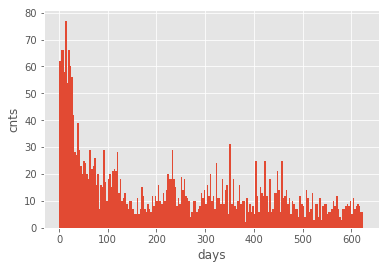

In [182]:
# 处理时间戳一列，观察twitter发送时间是否存在规律，如果中间有大块缺失，可能意味着我们丢了一段时间的数据
import datetime
for index, row in df.iterrows():
    df.loc[index, 'ts'] = datetime.datetime.strptime(row['timestamp'], "%Y-%m-%d %H:%M:%S %z").timestamp()
df['ts'] -= df['ts'].min()
# display.display(df)
df['ts'] /= 86400

# twitter发送时间直方图
df['ts'].hist(bins=200)
plt.xlabel('days')
plt.ylabel('cnts')
plt.show()

从上图可以看出，时间数据较为连续，在开始几天活动比较活跃之外，之后会有波动但依然正常，看不出明显的有数据缺失。

In [15]:
df['text'].value_counts()

This is Frankie. He's wearing blush. 11/10 really accents the cheek bones https://t.co/iJABMhVidf                                             8
This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1                                   8
This is Sunny. She was also a very good First Doggo. 14/10 would also be an absolute honor to pet https://t.co/YOC1fHFCSb                     8
This is Scout. He really wants to kiss himself. H*ckin inappropriate. 11/10 narcissistic af https://t.co/x0gV2Ck3AD                           8
This is Dave. He's currently in a predicament. Doesn't seem to mind tho. 12/10 someone assist Dave https://t.co/nfprKAXqwu                    6
                                                                                                                                             ..
This is Archie. He hears everything you say. Doesn't matter where you are. 12/10 https://t.co/0l4I8famYp                                

可见上述有重复的text，我们看是否tweet_id也相同？

In [16]:
df[['tweet_id', 'text']].duplicated().value_counts()

False    1994
True      929
dtype: int64

看来这些条目的确是重复的，后续需要去除。

In [17]:
df['rating_numerator'].value_counts()

12     734
11     591
10     541
13     482
9      171
      ... 
45       1
75       1
99       1
121      1
144      1
Name: rating_numerator, Length: 34, dtype: int64

In [18]:
df['rating_numerator'].describe()

count   2923.0
mean      12.2
std       34.4
min        0.0
25%       10.0
50%       11.0
75%       12.0
max     1776.0
Name: rating_numerator, dtype: float64

In [19]:
df[df['rating_numerator'] > 1000]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,ts
1314,749981277374128128,2016-07-04 15:00:45 +0000,This is Atticus. He's quite simply America af....,1776,10,Atticus,None,None,None,None,...,bow_tie,0.5,False,sunglasses,0.1,False,sunglass,0.1,False,231.7


In [20]:
df[df['rating_numerator'] > 50]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,ts
557,820690176645140481,2017-01-15 17:52:40 +0000,The floofs have been released I repeat the flo...,84,70,None,None,None,None,None,...,West_Highland_white_terrier,0.9,True,kuvasz,0.1,True,Samoyed,0.0,True,426.8
558,820690176645140481,2017-01-15 17:52:40 +0000,The floofs have been released I repeat the flo...,84,70,None,None,None,None,None,...,West_Highland_white_terrier,0.9,True,kuvasz,0.1,True,Samoyed,0.0,True,426.8
559,820690176645140481,2017-01-15 17:52:40 +0000,The floofs have been released I repeat the flo...,84,70,None,None,None,None,None,...,West_Highland_white_terrier,0.9,True,kuvasz,0.1,True,Samoyed,0.0,True,426.8
912,786709082849828864,2016-10-13 23:23:56 +0000,"This is Logan, the Chow who lived. He solemnly...",75,10,Logan,None,None,None,None,...,Pomeranian,0.5,True,Persian_cat,0.1,False,chow,0.1,True,333.0
1195,758467244762497024,2016-07-28 01:00:57 +0000,Why does this never happen at my front door......,165,150,None,None,None,None,None,...,Labrador_retriever,0.4,True,Chihuahua,0.1,True,American_Staffordshire_terrier,0.1,True,255.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,684222868335505415,2016-01-05 04:00:18 +0000,Someone help the girl is being mugged. Several...,121,110,None,None,None,None,None,...,soft-coated_wheaten_terrier,0.8,True,cocker_spaniel,0.1,True,teddy,0.1,False,50.2
2303,677716515794329600,2015-12-18 05:06:23 +0000,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120,None,None,None,None,None,...,teddy,0.7,False,crib,0.0,False,chow,0.0,True,32.3
2370,675853064436391936,2015-12-13 01:41:41 +0000,Here we have an entire platoon of puppers. Tot...,88,80,None,None,None,None,None,...,Labrador_retriever,0.9,True,golden_retriever,0.0,True,vizsla,0.0,True,27.1
2371,675853064436391936,2015-12-13 01:41:41 +0000,Here we have an entire platoon of puppers. Tot...,88,80,None,None,None,None,None,...,Labrador_retriever,0.9,True,golden_retriever,0.0,True,vizsla,0.0,True,27.1


质量问题2：分子出现极端值 1776  
质量问题3：分子分母成比例，导致同列的分子单位不一致，即不为 1/10

In [21]:
df['rating_denominator'].value_counts()

10     2898
11        5
80        3
70        3
50        3
       ... 
110       1
90        1
40        1
20        1
2         1
Name: rating_denominator, Length: 15, dtype: int64

质量问题4：分母不全都为10

In [22]:
df['name'].value_counts()

None       765
a           67
Bo          18
Charlie     18
Cooper      18
          ... 
Mo           1
Robin        1
Berb         1
Timber       1
Mattie       1
Name: name, Length: 936, dtype: int64

质量问题4：部分名字提取不正确，有 765个"None" 和 67个"a"，,还有一个叫'space'，不是大写，可能有问题

质量问题5：狗狗的stage不全，还有"blep", "snoot"  
整洁问题1：不应该将狗的stage分成doggo、floofer、pupper、puppo四列，以独热编码方式记录，应该记为一列‘stage’，而为真的原列名为内容。

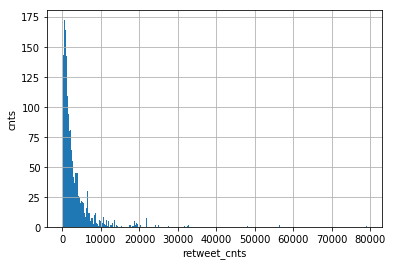

In [23]:
df['retweet_count'].hist(bins=500)
plt.xlabel('retweet_cnts')
plt.ylabel('cnts')
plt.show()

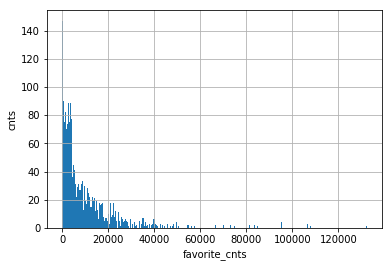

In [24]:
df['favorite_count'].hist(bins=500)
plt.xlabel('favorite_cnts')
plt.ylabel('cnts')
plt.show()

In [25]:
df[['p1', 'p1_conf', 'p1_dog']].sample(5)

,p1,p1_conf,p1_dog
534,malinois,0.3,True
2607,toy_poodle,0.3,True
1870,Pembroke,1.0,True
629,Border_collie,0.5,True
577,prison,0.9,False


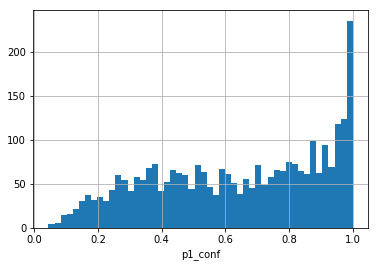

In [27]:
df['p1_conf'].hist(bins=50)
plt.xlabel('p1_conf')
plt.show()

kinds of predicted dogs: 111
number of predicted dogs: 2221


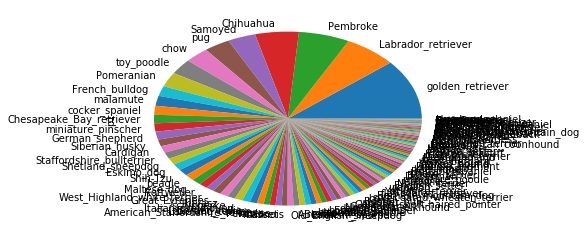

In [28]:
# 狗的种类有多少种？
print("kinds of predicted dogs: %r" % len(df[df['p1_dog'] == True]['p1'].value_counts()))
print("number of predicted dogs: %r" % df[df['p1_dog'] == True]['p1'].value_counts().sum())
df[df['p1_dog'] == True]['p1'].value_counts().plot(kind='pie')
plt.show()

### 2. 对项目数据进行清洗
对你在评估时列出的每个问题进行清洗，展示清洗的过程。结果应该为一个优质干净整洁的主数据集（pandas DataFrame 类型）

**质量问题**

1. tweet_id存在重复
2. 质量问题2：分子出现极端值 1776  
3. 质量问题3：分子分母成比例，导致同列的分子单位不一致，即不为 1/10
4. 质量问题4：分母不全都为10
5. 质量问题4：部分名字提取不正确，有 765个"None" 和 67个"a"，,还有一个叫'space'，不是大写，可能有问题
6. 质量问题5：狗狗的stage不全，还有"blep", "snoot" ,"BlepiPen"
7. 质量问题6：有一部分用户上传的图片不是狗狗照片，不应该被记录在这个项目中。 
8. 有些情况，存在狗狗有两个stage，查看后，发现这种情况对应的情况包括：图片中有2只狗狗、作者进行比较的时候提及了另一stage等，因为情况复杂且数量相对很少（11个），可以删掉。
9. 漏将floof归类为floofer。



**整洁问题**

1. 将3个表描述的是同一个事，应合并成一个表
2. 不应该将狗的stage分成doggo、floofer、pupper、puppo四列，以独热编码方式记录，应该记为一列‘stage’，而为真的原列名为内容。

In [30]:
df_before_clean = df.copy()

In [31]:
# df = df_before_clean.copy()

解决质量问题1（tweet_id 存在重复）：去除重复项

In [33]:
# df[df[['tweet_id']].duplicated()]

In [34]:
df.drop_duplicates(subset=['tweet_id'],inplace=True)

解决  
- 质量问题2：分子出现极端值 1776
- 质量问题3：分子分母成比例，导致同列的分子单位不一致，单位不为 1/10，即不一致
- 质量问题4：分母不全都为10

In [35]:
df[df['rating_denominator'] != 10]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,ts
557,820690176645140481,2017-01-15 17:52:40 +0000,The floofs have been released I repeat the flo...,84,70,None,None,None,None,None,...,West_Highland_white_terrier,0.9,True,kuvasz,0.1,True,Samoyed,0.0,True,426.8
678,810984652412424192,2016-12-19 23:06:23 +0000,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7,Sam,None,None,None,None,...,golden_retriever,0.9,True,Tibetan_mastiff,0.0,True,Labrador_retriever,0.0,True,400.0
1195,758467244762497024,2016-07-28 01:00:57 +0000,Why does this never happen at my front door......,165,150,None,None,None,None,None,...,Labrador_retriever,0.4,True,Chihuahua,0.1,True,American_Staffordshire_terrier,0.1,True,255.1
1430,740373189193256964,2016-06-08 02:41:38 +0000,"After so many requests, this is Bretagne. She ...",9,11,None,None,None,None,None,...,golden_retriever,0.8,True,kuvasz,0.1,True,Labrador_retriever,0.0,True,205.2
1508,731156023742988288,2016-05-13 16:15:54 +0000,Say hello to this unbelievably well behaved sq...,204,170,this,None,None,None,None,...,lakeside,0.5,False,breakwater,0.1,False,king_penguin,0.0,False,179.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,684222868335505415,2016-01-05 04:00:18 +0000,Someone help the girl is being mugged. Several...,121,110,None,None,None,None,None,...,soft-coated_wheaten_terrier,0.8,True,cocker_spaniel,0.1,True,teddy,0.1,False,50.2
2170,682962037429899265,2016-01-01 16:30:13 +0000,This is Darrel. He just robbed a 7/11 and is i...,7,11,Darrel,None,None,None,None,...,dingo,0.3,False,Chihuahua,0.2,True,loupe,0.2,False,46.7
2303,677716515794329600,2015-12-18 05:06:23 +0000,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120,None,None,None,None,None,...,teddy,0.7,False,crib,0.0,False,chow,0.0,True,32.3
2370,675853064436391936,2015-12-13 01:41:41 +0000,Here we have an entire platoon of puppers. Tot...,88,80,None,None,None,None,None,...,Labrador_retriever,0.9,True,golden_retriever,0.0,True,vizsla,0.0,True,27.1


上述数据中，只有第2902行，评分 1/2 数据过于奇怪，其他列在约分之后都可以保留

In [36]:
df = df.drop([2902])

In [37]:
df[df['rating_denominator'] != 10]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,ts
557,820690176645140481,2017-01-15 17:52:40 +0000,The floofs have been released I repeat the flo...,84,70,None,None,None,None,None,...,West_Highland_white_terrier,0.9,True,kuvasz,0.1,True,Samoyed,0.0,True,426.8
678,810984652412424192,2016-12-19 23:06:23 +0000,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7,Sam,None,None,None,None,...,golden_retriever,0.9,True,Tibetan_mastiff,0.0,True,Labrador_retriever,0.0,True,400.0
1195,758467244762497024,2016-07-28 01:00:57 +0000,Why does this never happen at my front door......,165,150,None,None,None,None,None,...,Labrador_retriever,0.4,True,Chihuahua,0.1,True,American_Staffordshire_terrier,0.1,True,255.1
1430,740373189193256964,2016-06-08 02:41:38 +0000,"After so many requests, this is Bretagne. She ...",9,11,None,None,None,None,None,...,golden_retriever,0.8,True,kuvasz,0.1,True,Labrador_retriever,0.0,True,205.2
1508,731156023742988288,2016-05-13 16:15:54 +0000,Say hello to this unbelievably well behaved sq...,204,170,this,None,None,None,None,...,lakeside,0.5,False,breakwater,0.1,False,king_penguin,0.0,False,179.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,684225744407494656,2016-01-05 04:11:44 +0000,"Two sneaky puppers were not initially seen, mo...",143,130,None,None,None,None,None,...,golden_retriever,0.2,True,Samoyed,0.1,True,Great_Pyrenees,0.1,True,50.2
2145,684222868335505415,2016-01-05 04:00:18 +0000,Someone help the girl is being mugged. Several...,121,110,None,None,None,None,None,...,soft-coated_wheaten_terrier,0.8,True,cocker_spaniel,0.1,True,teddy,0.1,False,50.2
2170,682962037429899265,2016-01-01 16:30:13 +0000,This is Darrel. He just robbed a 7/11 and is i...,7,11,Darrel,None,None,None,None,...,dingo,0.3,False,Chihuahua,0.2,True,loupe,0.2,False,46.7
2303,677716515794329600,2015-12-18 05:06:23 +0000,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120,None,None,None,None,None,...,teddy,0.7,False,crib,0.0,False,chow,0.0,True,32.3


In [38]:
# 将分子统一标准，分母记为10
index = df['rating_denominator'] != 10
for i, todrop in index.iteritems():
    if todrop:
        df.loc[i, 'rating_numerator'] /= df.loc[i, 'rating_denominator']
        df.loc[i, 'rating_numerator'] *= 10
        df.loc[i, 'rating_numerator'] = int(df.loc[i, 'rating_numerator'])
        df.loc[i, 'rating_denominator'] = 10

In [39]:
# df[index]

In [40]:
# df = df_before_clean.copy()

In [41]:
df['rating_numerator'].describe()

count   1993.0
mean      11.7
std       40.7
min        0.0
25%       10.0
50%       11.0
75%       12.0
max     1776.0
Name: rating_numerator, dtype: float64

In [42]:
df[df['rating_numerator'] > 1000]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,ts
1314,749981277374128128,2016-07-04 15:00:45 +0000,This is Atticus. He's quite simply America af....,1776.0,10,Atticus,None,None,None,None,...,bow_tie,0.5,False,sunglasses,0.1,False,sunglass,0.1,False,231.7


In [43]:
df[df['rating_numerator'] > 15]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,ts
678,810984652412424192,2016-12-19 23:06:23 +0000,Meet Sam. She smiles 24/7 &amp; secretly aspir...,34.0,10,Sam,None,None,None,None,...,golden_retriever,0.9,True,Tibetan_mastiff,0.0,True,Labrador_retriever,0.0,True,400.0
912,786709082849828864,2016-10-13 23:23:56 +0000,"This is Logan, the Chow who lived. He solemnly...",75.0,10,Logan,None,None,None,None,...,Pomeranian,0.5,True,Persian_cat,0.1,False,chow,0.1,True,333.0
1019,778027034220126208,2016-09-20 00:24:34 +0000,This is Sophie. She's a Jubilant Bush Pupper. ...,27.0,10,Sophie,None,None,pupper,None,...,clumber,0.9,True,cocker_spaniel,0.0,True,Lhasa,0.0,True,309.1
1314,749981277374128128,2016-07-04 15:00:45 +0000,This is Atticus. He's quite simply America af....,1776.0,10,Atticus,None,None,None,None,...,bow_tie,0.5,False,sunglasses,0.1,False,sunglass,0.1,False,231.7
2228,680494726643068929,2015-12-25 21:06:00 +0000,Here we have uncovered an entire battalion of ...,26.0,10,None,None,None,None,None,...,kuvasz,0.4,True,Samoyed,0.1,True,Great_Pyrenees,0.1,True,39.9
2638,670842764863651840,2015-11-29 05:52:33 +0000,After so many requests... here you go.\r\n\r\n...,420.0,10,None,None,None,None,None,...,microphone,0.1,False,accordion,0.1,False,drumstick,0.1,False,13.3


将超出15分的部分截断到15

In [44]:
# 将超出15分的分子截断到15
index = df['rating_numerator'] >= 15
for i, todrop in index.iteritems():
    if todrop:
        df.loc[i, 'rating_numerator'] = 15
# df[df['rating_numerator'] > 14]["rating_numerator"] = 15
df[df['rating_numerator'] > 15]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,ts


质量问题7：有一部分用户上传的图片不是狗狗照片，不应该被记录在这个项目中。

In [46]:
# 从df中删除姓名为'None'且不是狗狗的条目
def not_dogs(s):
    if ('only rate dogs' in s.lower()) or ('send only dogs' in s.lower()):
        return True
    else:
        return False
index_not_dog = df.text.apply(not_dogs)
df = df.drop(index_not_dog[index_not_dog == True].index)

质量问题7：部分名字提取不正确，有 765个"None" 和 67个"a"，,还有一个叫'space'，不是大写，可能有问题

但我对姓名并不感兴趣，发现提取失败的情况中除了非狗狗的情况并没有给我带来太大麻烦，故不予处理。

因为我发现在没有搜到名字的情况中，存在相当的情况是由于用户传入的不是狗的图片，导致姓名列提取出错。我又发现在出错的情况中，text列中一般会有"only send dogs"和"we only rate dogs"的字样，通过提取'only'字眼，我们可以大概率去除非狗狗的照片

In [47]:
# 从df中删除姓名为'None'且不是狗狗的条目
def not_dogs(s):
    if 'only' in s.lower():
        return True
    else:
        return False
index_not_dog = (df.text.apply(not_dogs)) & (df['name'] == 'None')
df = df.drop(index)

质量问题8：狗狗的stage不全，还有"blep", "snoot"等

In [48]:
# 从df['text']中找到'blep'和'snoot'
def blep_or_snoot(s):
    if ('blep' in s.lower()) or ('snoot' in s.lower()) or ('blepipen' in s.lower()) :
        return True
    else:
        return False
index_blep_or_snoot = df.text.apply(blep_or_snoot)

index_blep_or_snoot

2       False
3       False
4       False
6       False
7       False
        ...  
2918    False
2919    False
2920    False
2921    False
2922    False
Name: text, Length: 1936, dtype: bool

In [49]:
df[index_blep_or_snoot]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,ts
40,886366144734445568,2017-07-15 23:25:31 +0000,This is Roscoe. Another pupper fallen victim t...,12.0,10,Roscoe,None,None,pupper,None,...,French_bulldog,1.0,True,Chihuahua,0.0,True,Boston_bull,0.0,True,608.0
84,880221127280381952,2017-06-29 00:27:25 +0000,Meet Jesse. He's a Fetty Woof. His tongue ejec...,12.0,10,Jesse,None,None,None,None,...,Chihuahua,0.2,True,meerkat,0.1,False,clumber,0.1,True,591.1
175,865359393868664832,2017-05-19 00:12:11 +0000,This is Sammy. Her tongue ejects without warni...,13.0,10,Sammy,None,None,None,None,...,Chesapeake_Bay_retriever,0.8,True,Labrador_retriever,0.2,True,Weimaraner,0.0,True,550.1
687,809448704142938112,2016-12-15 17:23:04 +0000,"I call this one ""A Blep by the Sea"" 12/10 http...",12.0,10,None,None,None,None,None,...,Greater_Swiss_Mountain_dog,0.4,True,Cardigan,0.1,True,English_springer,0.1,True,395.8


In [50]:
# df.loc[40, 'text']
# df.loc[84, 'text']
# df.loc[175, 'text']
# df.loc[687, 'text']

通过对上述情况进行查看，发现'BlepiPen'的标签非常少见，只有3个，没有分析价值。可以删去。故我们可以认为狗狗的stage只有4类。

In [51]:
df = df.drop(index_blep_or_snoot[index_blep_or_snoot == True].index)

**整洁问题**  
- 整洁问题1：不应该将狗的stage分成doggo、floofer、pupper、puppo四列，以独热编码方式记录。应该记为一列‘stage’，而为真的原列名为内容。

In [53]:
df['doggo'].value_counts()

None     1858
doggo      74
Name: doggo, dtype: int64

In [54]:
df['floofer'].value_counts()

None       1924
floofer       8
Name: floofer, dtype: int64

In [55]:
df['pupper'].value_counts()

None      1721
pupper     211
Name: pupper, dtype: int64

In [56]:
df['puppo'].value_counts()

None     1909
puppo      23
Name: puppo, dtype: int64

发现有把一个狗归到多个类中的情况，对应的文字为：

In [57]:
df.loc[253, ['text', 'doggo', 'floofer', 'pupper', 'puppo']]

text       At first I thought this was a shy doggo, but i...
doggo                                                  doggo
floofer                                              floofer
pupper                                                  None
puppo                                                   None
Name: 253, dtype: object

In [58]:
df.loc[253,'text']

"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk"

In [59]:
for i, v in enumerate(df.columns.values):
    print(i, v)

0 tweet_id
1 timestamp
2 text
3 rating_numerator
4 rating_denominator
5 name
6 doggo
7 floofer
8 pupper
9 puppo
10 retweet_count
11 favorite_count
12 p1
13 p1_conf
14 p1_dog
15 p2
16 p2_conf
17 p2_dog
18 p3
19 p3_conf
20 p3_dog
21 ts


质量问题8：有些情况，存在狗狗有两个stage，查看后，发现这种情况对应的情况包括：图片中有2只狗狗、作者进行比较的时候提及了另一stage等，因为情况复杂且数量相对很少（11个），可以删掉。

In [60]:
# 创建一列新的列名为'num_stage'，其内容为doggo、floofer、pupper、puppo列中不为None的个数
for i, row in df.iterrows():
    cols = ['doggo', 'floofer', 'pupper','puppo']
#     cols = [6,7,8,9]
    n_stage = 0
    for col in cols:
        if row[col] != 'None':
            n_stage += 1
    df.loc[i, 'n_stage'] = n_stage

print(df['n_stage'].value_counts())

for i,v in df[df['n_stage'] == 2].iterrows():
    print(i, '\t', v['text'])

0.0    1627
1.0     294
2.0      11
Name: n_stage, dtype: int64
239 	 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
253 	 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
602 	 This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
695 	 Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
737 	 Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
745 	 This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
922 	 This is Pinot. He's a sophisticated doggo. Yo

In [61]:
df = df.drop(df[df['n_stage'] == 2].index.values)

解决问题9：
将floof也合并到floofer一列中

In [62]:
def with_floof(s):
    return True if 'floof' in s.lower() else False

for i,row in df.iterrows():
    if with_floof(row['text']):
        df.loc[i, 'floofer'] = 'floofer'
# df[df.floofer != 'None']

In [63]:
# 创建一列新的列名为'stage'，其内容为doggo、floofer、pupper、puppo或者None
for i, row in df.iterrows():
    cols = ['doggo', 'floofer', 'pupper','puppo']
    name = 'None'
    for col in cols:
        if row[col] != 'None':
            name = col
    df.loc[i, 'stage'] = name

print(df['stage'].value_counts())

None       1603
pupper      202
doggo        62
floofer      32
puppo        22
Name: stage, dtype: int64


整洁问题2：需要将三个表合为一张表。

### 3. 对项目数据进行存储、分析和可视化
将清理后的数据集存储到 CSV 文件中，命名为 twitter_archive_master.csv
可视化必须生成至少 3 个见解和 1 个可视化。

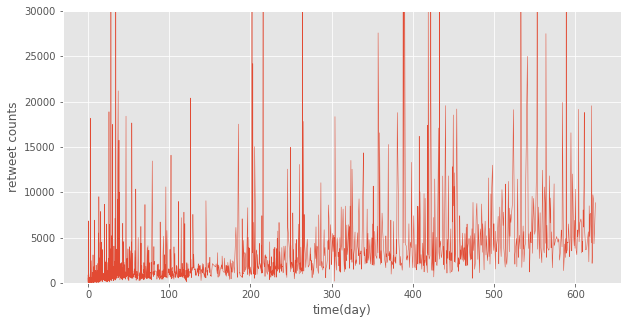

In [183]:
data = df[['ts', 'retweet_count']].copy()
data = data.sort_values(by='ts')
plt.figure(figsize=(10,5))
plt.plot(data.ts.values, data.retweet_count.values, linewidth=.5)
plt.xlabel('time(day)')
plt.ylabel('retweet counts')
plt.ylim((0, 30000))
plt.show()

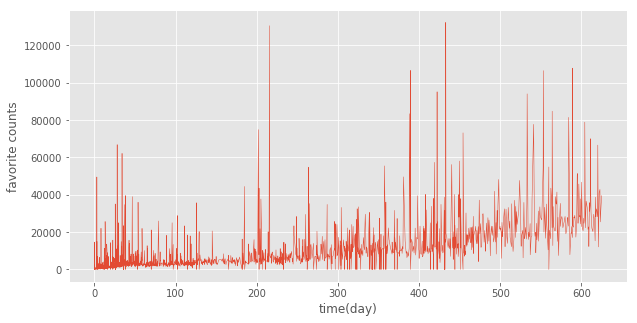

In [188]:
data = df[['ts', 'favorite_count']].copy()
data = data.sort_values(by='ts')
plt.figure(figsize=(10,5))
plt.plot(data.ts.values, data.favorite_count.values, linewidth=.5)
plt.xlabel('time(day)')
plt.ylabel('favorite counts')
# plt.ylim((0, 60000))
plt.show()

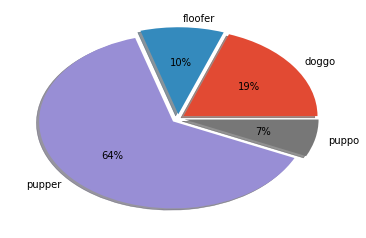

In [116]:
# data
labels = ['doggo', 'floofer', 'pupper','puppo']
data = df['stage'].value_counts().loc[labels]
labels = data.index
fracs = data.values
explode = (0.05, 0.05, 0.05, 0.05)
plt.pie(fracs, explode=explode, labels=labels, autopct='%.0f%%', shadow=True)
plt.show()

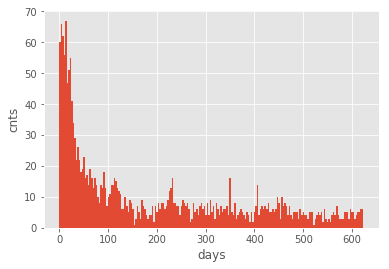

In [127]:
# twitter发送时间直方图
df['ts'].hist(bins=200)
plt.xlabel('days')
plt.ylabel('cnts')
plt.show()

kinds of predicted dogs: 111
number of predicted dogs: 2221


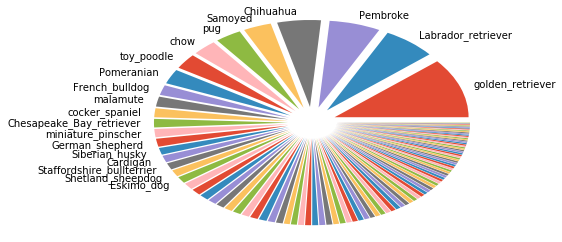

In [180]:
# 预测的狗的种类有多少种？
print("kinds of predicted dogs: %r" % len(df[df['p1_dog'] == True]['p1'].value_counts()))
print("number of predicted dogs: %r" % df[df['p1_dog'] == True]['p1'].value_counts().sum())
data = df[df['p1_dog'] == True]['p1'].value_counts()
labels = list(data.index.values[:20]) + [''] * (len(data) - 20)
plt.pie(data,
        labels=labels,
        explode=[0.18]*len(data)
       )
plt.show()

预测是否准确？
如果预测p1不正确，那么p2应该

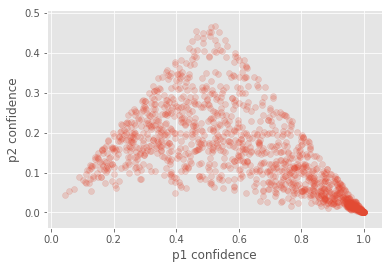

In [171]:
# 预测均为狗的时候，看预测p1的可信度和预测p2的可信度满足的关系，在[0,0.5]区间正相关，[0.5,1]区间负相关
data = df[(df['p1_dog'] == True) & (df['p2_dog'] == True)]
plt.scatter(data.p1_conf, data.p2_conf, alpha = 0.2)
plt.xlabel("p1 confidence")
plt.ylabel("p2 confidence")
plt.show()

In [190]:
# 保存清洗和合并好的数据集
df.to_csv('twitter_archive_master.csv')

## 项目汇报

创建一个 **300-600字**的书面报告，命名为 wrangle_report.pdf，在该报告中简要描述你的数据整理过程。这份报告可以看作是一份内部文档，供你的团队成员查看交流。

创建一个 **250字以上**的书面报告，命名为 act_report.pdf，在该报告中，你可以与读者交流观点，展示你使用整理过的数据生成的可视化图表。这份报告可以看作是一份外部文档，如博客帖子或杂志文章。

## 项目提交
[审阅标准](https://review.udacity.com/#!/rubrics/1332/view)


包含以下文件，然后单击项目 workspace 页面右下角的“提交项目”：

- wrangle_act.ipynb：用于收集、评估、清洗、分析和可视化数据的代码
- wrangle_report.pdf：汇总数据整理步骤的文档：收集，评估和清洗
- act_report.pdf：对最终数据进行观察与分析的文档
- twitter_archive_enhanced.csv：给定的文件
- image_predictions.tsv：以编程方式下载的文件
- tweet_json.txt：通过 API 构建的文件
- twitter_archive_master.csv：合并与清洗后的数据